In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# Data Loading

In [2]:
import os
import requests
import csv

# Function to search recordings for a given species on Xeno Canto
def search_xeno_canto(species):
    url = f"https://www.xeno-canto.org/api/2/recordings?query={species}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data['recordings']
    else:
        print(f"Error: Failed to fetch recordings for {species} from Xeno Canto API")
        return []

# Function to download recording file
def download_recording(recording, species):
    file_url = recording['file']
    file_name = f"{recording['id']}-{species.replace(' ', '_')}.mp3"  # Use recording ID and species name as file name
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(os.path.join("audio_files", file_name), 'wb') as f:
            f.write(response.content)
        return file_name
    else:
        print(f"Error: Failed to download recording {file_url}")
        return None

# Function to create CSV file with metadata
def create_csv(metadata, csv_file):
    with open(csv_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=metadata[0].keys())
        writer.writeheader()
        writer.writerows(metadata)

# List of species to download
species_to_download = [
    "Eurasian Hoopoe",
    "European Bee-eater",
    "Sardinian Warbler",
    "Crested Lark"
    
]

# Create directory to store audio files
if not os.path.exists("audio_files"):
    os.makedirs("audio_files")

# Iterate over each species and download recordings
metadata = []
for species in species_to_download:
    recordings = search_xeno_canto(species)
    print(f"Found {len(recordings)} recordings of {species}")

    for recording in recordings:
        file_name = download_recording(recording, species)
        if file_name:
            metadata.append({
                'File Name': file_name,
                'Species': species,
                'Path': os.path.join("audio_files", file_name),
                'Location': recording.get('loc', ''),
                'Recorder': recording.get('rec', ''),
                'Date': recording.get('date', ''),
                'Duration': recording.get('length', '')
            })

# Create CSV file
csv_file = "bird_recordings_metadata.csv"
create_csv(metadata, csv_file)
print(f"CSV file created: {csv_file}")


Found 500 recordings of Eurasian Hoopoe
Error: Failed to download recording https://xeno-canto.org/891005/download
Error: Failed to download recording https://xeno-canto.org/891004/download
Error: Failed to download recording https://xeno-canto.org/798809/download
Error: Failed to download recording https://xeno-canto.org/798808/download
Error: Failed to download recording https://xeno-canto.org/798807/download
Error: Failed to download recording https://xeno-canto.org/798806/download
Error: Failed to download recording https://xeno-canto.org/798805/download
Found 500 recordings of European Bee-eater
Found 500 recordings of Sardinian Warbler
Found 500 recordings of Crested Lark
CSV file created: bird_recordings_metadata.csv


# Data preprocessing

In [25]:
# Read the CSV file into a DataFrame
df = pd.read_csv("bird_recordings_metadata.csv")


In [26]:
# Drop specified columns
columns_to_drop = ['Location', 'Recorder', 'Date']
df.drop(columns=columns_to_drop, inplace=True)

# Print the modified DataFrame
print(df)

                       File Name          Species  \
0     899066-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
1     896598-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
2     894134-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
3     893802-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
4     893801-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
...                          ...              ...   
1778     470764-Crested_Lark.wav     Crested Lark   
1779     464447-Crested_Lark.wav     Crested Lark   
1780     464351-Crested_Lark.wav     Crested Lark   
1781     443936-Crested_Lark.wav     Crested Lark   
1782     434993-Crested_Lark.wav     Crested Lark   

                                                  Path Duration  
0     audio_files_converted/899066-Eurasian_Hoopoe.wav     0:44  
1     audio_files_converted/896598-Eurasian_Hoopoe.wav     0:27  
2     audio_files_converted/894134-Eurasian_Hoopoe.wav     0:30  
3     audio_files_converted/893802-Eurasian_Hoopoe.wav     0:29  
4     audio_files_converted/89380

# 1. Converting MP3 audios into WAV

In [5]:
#!pip install pandas pydub



In [23]:
from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError

# Define paths
audio_dir = '/kaggle/working/audio_files'
csv_path = '/kaggle/working/bird_recordings_metadata.csv'
output_dir = '/kaggle/working/audio_files_converted'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Read CSV file
df = pd.read_csv(csv_path)

# Function to convert MP3 to WAV
def convert_to_wav(mp3_path, output_dir):
    try:
        sound = AudioSegment.from_mp3(mp3_path)
        wav_path = os.path.join(output_dir, os.path.splitext(os.path.basename(mp3_path))[0] + '.wav')
        sound.export(wav_path, format="wav")
        return wav_path, None
    except CouldntDecodeError as e:
        return None, str(e)

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    # Original MP3 path
    mp3_path = os.path.join(audio_dir, row['File Name'])
    
    # Convert MP3 to WAV
    wav_path, error = convert_to_wav(mp3_path, output_dir)
    
    if wav_path:
        # Update CSV row with new WAV path and filename
        df.at[index, 'File Name'] = os.path.basename(wav_path)
        df.at[index, 'Path'] = os.path.join('audio_files_converted', os.path.basename(wav_path))
    else:
        print(f"Conversion failed for file '{row['File Name']}': {error}")

# Save updated DataFrame to CSV
df.to_csv(csv_path, index=False)

print("Conversion and CSV update completed successfully.")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/audio_files/899066-Eurasian_Hoopoe.wav'

In [27]:
# Print the modified DataFrame
print(df)

                       File Name          Species  \
0     899066-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
1     896598-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
2     894134-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
3     893802-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
4     893801-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
...                          ...              ...   
1778     470764-Crested_Lark.wav     Crested Lark   
1779     464447-Crested_Lark.wav     Crested Lark   
1780     464351-Crested_Lark.wav     Crested Lark   
1781     443936-Crested_Lark.wav     Crested Lark   
1782     434993-Crested_Lark.wav     Crested Lark   

                                                  Path Duration  
0     audio_files_converted/899066-Eurasian_Hoopoe.wav     0:44  
1     audio_files_converted/896598-Eurasian_Hoopoe.wav     0:27  
2     audio_files_converted/894134-Eurasian_Hoopoe.wav     0:30  
3     audio_files_converted/893802-Eurasian_Hoopoe.wav     0:29  
4     audio_files_converted/89380

In [29]:
# Count the occurrences of each species
species_counts = df['Species'].value_counts()

# Print the number of rows for each species
print("Number of rows for each species:")
for species, count in species_counts.items():
    print(f"{species}: {count}")

Number of rows for each species:
Crested Lark: 454
Sardinian Warbler: 445
Eurasian Hoopoe: 444
European Bee-eater: 440


In [30]:
# Define paths
converted_audio_dir = '/kaggle/working/audio_files_converted'
original_audio_dir = '/kaggle/working/audio_files'

# Count audio files in the converted directory
converted_audio_count = len([f for f in os.listdir(converted_audio_dir) if f.endswith('.wav')])

# Count audio files in the original directory
original_audio_count = len([f for f in os.listdir(original_audio_dir) if f.endswith('.mp3')])

print("Number of audio files in 'audio_files_converted' directory:", converted_audio_count)
print("Number of audio files in 'audio_files' directory:", original_audio_count)

Number of audio files in 'audio_files_converted' directory: 0
Number of audio files in 'audio_files' directory: 1993


In [31]:
# Remove lines with file names containing ".mp3"
df = df[~df['File Name'].str.contains('.mp3', case=False)]

# Save the modified DataFrame back to the CSV file
df.to_csv(csv_path, index=False)

print("Lines with file names containing '.mp3' extension removed successfully.")


Lines with file names containing '.mp3' extension removed successfully.


In [32]:
print(df.shape)

(1783, 4)


# 2. Splitting Train and Test Data

In [33]:

from sklearn.model_selection import train_test_split



# Define the species categories
species = ["Eurasian Hoopoe", "European Bee-eater", "Sardinian Warbler", "Crested Lark"]

# Initialize empty lists to store train and test data
train_data = []
test_data = []

# Shuffle and split data for each species
for specie in species:
    # Select rows corresponding to the current species
    species_data = df[df['Species'] == specie]
    
    # Shuffle the rows of the current species data
    species_data = species_data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split the shuffled data into train and test
    train_specie, test_specie = train_test_split(species_data, test_size=0.2, random_state=42)
    
    # Append the train and test data for the current species to the respective lists
    train_data.append(train_specie)
    test_data.append(test_specie)

# Concatenate the train and test data for all species
train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

# Shuffle the concatenated train and test data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save train and test CSV files
train_csv_path = '/kaggle/working/train.csv'
test_csv_path = '/kaggle/working/test.csv'

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print("Train and test CSV files saved successfully.")


Train and test CSV files saved successfully.


In [34]:
# Load the train and test CSV files
train_csv_path = '/kaggle/working/train.csv'
test_csv_path = '/kaggle/working/test.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Print the shape of the train and test CSV files
print("Train CSV shape:", train_df.shape)
print("Test CSV shape:", test_df.shape)

Train CSV shape: (1426, 4)
Test CSV shape: (357, 4)


In [35]:
import pandas as pd
import os
import shutil


# Define directories
audio_files_converted_dir = '/kaggle/working/audio_files_converted'
audio_train_dir = '/kaggle/working/audio_train'
audio_test_dir = '/kaggle/working/audio_test'

# Create directories if they do not exist
os.makedirs(audio_train_dir, exist_ok=True)
os.makedirs(audio_test_dir, exist_ok=True)

# Move audio files to train and test directories
for _, row in train_df.iterrows():
    audio_file_name = row['File Name']
    source_path = os.path.join(audio_files_converted_dir, audio_file_name)
    destination_path = os.path.join(audio_train_dir, audio_file_name)
    shutil.move(source_path, destination_path)

for _, row in test_df.iterrows():
    audio_file_name = row['File Name']
    source_path = os.path.join(audio_files_converted_dir, audio_file_name)
    destination_path = os.path.join(audio_test_dir, audio_file_name)
    shutil.move(source_path, destination_path)

print("Audio files moved to train and test directories.")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/audio_files_converted/804372-Eurasian_Hoopoe.wav'

# 3. Length Train Data Normalization

In [36]:
import os
import librosa
import numpy as np
import soundfile as sf

# Define the directory containing audio files
audio_train_dir = '/kaggle/working/audio_train'

# Define the target duration (in seconds)
target_duration = 20

# Iterate over audio files in the directory
for file_name in os.listdir(audio_train_dir):
    # Load audio file
    file_path = os.path.join(audio_train_dir, file_name)
    audio, sr = librosa.load(file_path, sr=None)
    
    # Compute duration of the audio file
    duration = librosa.get_duration(y=audio, sr=sr)
    
    # Pad or trim audio to target duration
    if duration < target_duration:
        # Pad audio if its duration is less than the target duration
        pad_length = int((target_duration - duration) * sr)
        audio = np.pad(audio, (0, pad_length), mode='constant')
    elif duration > target_duration:
        # Trim audio if its duration is greater than the target duration
        audio = audio[:int(target_duration * sr)]
    
    # Save the modified audio file
    sf.write(file_path, audio, sr)

print("Audio files length normalized to 20 seconds.")


Audio files length normalized to 20 seconds.


In [37]:
import os
import librosa

# Define the directory containing audio files
audio_train_dir = '/kaggle/working/audio_train'

# Define the target duration (in seconds)
target_duration = 20

# Initialize a counter for audio files of length 20s
count_20s = 0

# Iterate over audio files in the directory
for file_name in os.listdir(audio_train_dir):
    # Load audio file
    file_path = os.path.join(audio_train_dir, file_name)
    audio, sr = librosa.load(file_path, sr=None)
    
    # Compute duration of the audio file
    duration = librosa.get_duration(y=audio, sr=sr)
    
    # Check if duration is equal to target duration
    if duration == target_duration:
        count_20s += 1

print("Number of audio files of length 20s:", count_20s)


Number of audio files of length 20s: 1334


In [38]:
import os
import pandas as pd
import librosa

# Define the directory containing audio files and the CSV file
audio_train_dir = '/kaggle/working/audio_train'
csv_file_path = '/kaggle/working/train.csv'

# Load the CSV file
train_df = pd.read_csv(csv_file_path)

# Define the target duration (in seconds)
target_duration = 20

# Iterate over audio files in the directory
for file_name in os.listdir(audio_train_dir):
    # Load audio file
    file_path = os.path.join(audio_train_dir, file_name)
    audio, sr = librosa.load(file_path, sr=None)
    
    # Compute duration of the audio file
    duration = librosa.get_duration(y=audio, sr=sr)
    
    # Check if duration is not equal to the target duration
    if duration != target_duration:
        # Delete audio file
        os.remove(file_path)
        
        # Remove corresponding row from the CSV file
        file_name_without_extension = os.path.splitext(file_name)[0]
        train_df = train_df[train_df['File Name'] != file_name_without_extension]

# Save the modified CSV file
train_df.to_csv(csv_file_path, index=False)

print("Audio files with duration different than 20s deleted.")


Audio files with duration different than 20s deleted.


In [39]:
print(df.shape)

(1783, 4)


In [40]:
import os
import pandas as pd
import librosa

# Define the directory containing audio files and the CSV file
audio_train_dir = '/kaggle/working/audio_train'
csv_file_path = '/kaggle/working/train.csv'

# Load the CSV file
train_df = pd.read_csv(csv_file_path)

# Define the target duration (in seconds)
target_duration = 20

# Iterate over audio files in the directory
for file_name in os.listdir(audio_train_dir):
    # Load audio file
    file_path = os.path.join(audio_train_dir, file_name)
    audio, sr = librosa.load(file_path, sr=None)
    
    # Compute duration of the audio file
    duration = librosa.get_duration(y=audio, sr=sr)
    
    # Check if duration is not equal to the target duration
    if duration != target_duration:
        # Delete audio file
        os.remove(file_path)
        
        # Remove corresponding row from the CSV file
        file_name_without_extension = os.path.splitext(file_name)[0]
        train_df = train_df[train_df['File Name'] != file_name_without_extension]

# Save the modified CSV file
df.to_csv(csv_file_path, index=False)

print("Audio files with duration not equal to 20s deleted.")


Audio files with duration not equal to 20s deleted.


In [41]:
import os
import pandas as pd

# Define the directory containing audio files and the CSV file
audio_train_dir = '/kaggle/working/audio_train'
csv_file_path = '/kaggle/working/train.csv'

# Count the number of audio files in the directory
audio_file_count = len(os.listdir(audio_train_dir))

# Count the number of rows in the CSV file
train_df = pd.read_csv(csv_file_path)
csv_row_count = len(train_df)

print("Number of audio files:", audio_file_count)
print("Number of rows in the CSV file:", csv_row_count)


Number of audio files: 1334
Number of rows in the CSV file: 1783


In [42]:
import os
import pandas as pd

# Define the directory containing audio files and the CSV file
audio_train_dir = '/kaggle/working/audio_train'
csv_file_path = '/kaggle/working/train.csv'

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract the file name from the 'Path' column
    file_name = row['Path'].split('/')[-1]
    
    # Check if the audio file exists in the audio directory
    audio_file_path = os.path.join(audio_train_dir, file_name)
    if not os.path.exists(audio_file_path):
        # Delete the row from the DataFrame if the audio file does not exist
        df.drop(index, inplace=True)

# Save the modified CSV file
df.to_csv(csv_file_path, index=False)

print("Rows with non-existent audio files removed from the CSV file.")


Rows with non-existent audio files removed from the CSV file.


# MFCC Feature extraction

In [43]:
#TEST
import os
import numpy as np

# Define num_mfcc and n_frames
num_mfcc = 128
n_frames = 10

audio_train_dir = '/kaggle/working/audio_train'
csv_file_path = '/kaggle/working/train.csv'

# Process each audio file in the directory
max_length = 0  # Track the maximum length of MFCC features
mfcc_features = []
for file_name in df['Path']:
    if file_name.endswith('.wav'):
        file_path = os.path.join(audio_train_dir, file_name)
        mfcc = preprocess_audio(file_path, num_mfcc=num_mfcc)  # Updated function call
        mfcc = mfcc[:, :n_frames]  # Keep only the first n_frames
        mfcc_features.append(mfcc)
        max_length = max(max_length, mfcc.shape[1])  # Update max_length

# Pad or truncate MFCC features to have consistent shape
for i in range(len(mfcc_features)):
    mfcc_features[i] = np.pad(mfcc_features[i], ((0, 0), (0, max_length - mfcc_features[i].shape[1])), mode='constant')

# Convert list of MFCC features to NumPy array
mfcc_features = np.array(mfcc_features)

# Add MFCC features as a new column in the DataFrame
df['MFCC_Features'] = mfcc_features.tolist()

# Save the DataFrame to a new CSV file
new_csv_file_path = '/kaggle/working/train_with_mfcc.csv'
df.to_csv(new_csv_file_path, index=False)

print("MFCC features added to DataFrame and saved to CSV.")


NameError: name 'preprocess_audio' is not defined

In [45]:
import os
import pandas as pd
import librosa
import numpy as np

# Define the directory containing audio files and the CSV file
audio_train_dir = '/kaggle/working/audio_train'
csv_file_path = '/kaggle/working/train.csv'

# Define num_mfcc and n_frames
num_mfcc = 128
n_frames = 10

# Define preprocess_audio function to extract MFCC features
def preprocess_audio(file_path, num_mfcc=128, n_frames=10):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc)
    return mfcc[:, :n_frames]

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Initialize a list to store MFCC features
mfcc_features_list = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract the file name from the 'Path' column
    file_name = row['Path'].split('/')[-1]
    
    # Check if the audio file exists in the audio directory
    audio_file_path = os.path.join(audio_train_dir, file_name)
    if os.path.exists(audio_file_path):
        # Preprocess the audio file and append MFCC features to the list
        mfcc_features = preprocess_audio(audio_file_path, num_mfcc=num_mfcc, n_frames=n_frames)
        mfcc_features_list.append(mfcc_features.flatten())  # Flatten MFCC features into a 1D array
    else:
        # Drop the row from the DataFrame if the audio file does not exist
        df.drop(index, inplace=True)

# Convert the list of MFCC features to a NumPy array
mfcc_features_array = np.array(mfcc_features_list)

# Add MFCC features as a new column in the DataFrame
df['MFCC_Features'] = mfcc_features_array.tolist()

# Save the modified DataFrame to a new CSV file
new_csv_file_path = '/kaggle/working/train_with_mfcc.csv'
df.to_csv(new_csv_file_path, index=False)

print("MFCC features extracted and added to the DataFrame.")


MFCC features extracted and added to the DataFrame.


In [46]:
csv_file_path = '/kaggle/working/train_with_mfcc.csv'
df_with_mfcc = pd.read_csv(csv_file_path)

# Print the DataFrame
print(df_with_mfcc)

                       File Name          Species  \
0     896598-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
1     881187-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
2     871172-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
3     861531-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
4     861026-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
...                          ...              ...   
1329     473635-Crested_Lark.wav     Crested Lark   
1330     470764-Crested_Lark.wav     Crested Lark   
1331     464447-Crested_Lark.wav     Crested Lark   
1332     464351-Crested_Lark.wav     Crested Lark   
1333     443936-Crested_Lark.wav     Crested Lark   

                                                  Path Duration  \
0     audio_files_converted/896598-Eurasian_Hoopoe.wav     0:27   
1     audio_files_converted/881187-Eurasian_Hoopoe.wav     3:28   
2     audio_files_converted/871172-Eurasian_Hoopoe.wav     0:15   
3     audio_files_converted/861531-Eurasian_Hoopoe.wav     0:38   
4     audio_files_converted/

In [47]:

# Load the CSV file
csv_file_path = '/kaggle/working/train_with_mfcc.csv'
df_with_mfcc = pd.read_csv(csv_file_path)

# Add a new column 'European_Bee_eater' based on 'Species'
df_with_mfcc['European_Bee_eater'] = df_with_mfcc['Species'].apply(lambda x: 1 if x == 'European Bee-eater' else 0)

# Save the DataFrame with the new column to a new CSV file
new_csv_file_path = '/kaggle/working/train_with_mfcc_with_label.csv'
df_with_mfcc.to_csv(new_csv_file_path, index=False)

print("New feature added to DataFrame and saved to CSV.")


New feature added to DataFrame and saved to CSV.


In [48]:
# Print the DataFrame
print(df_with_mfcc)

                       File Name          Species  \
0     896598-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
1     881187-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
2     871172-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
3     861531-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
4     861026-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
...                          ...              ...   
1329     473635-Crested_Lark.wav     Crested Lark   
1330     470764-Crested_Lark.wav     Crested Lark   
1331     464447-Crested_Lark.wav     Crested Lark   
1332     464351-Crested_Lark.wav     Crested Lark   
1333     443936-Crested_Lark.wav     Crested Lark   

                                                  Path Duration  \
0     audio_files_converted/896598-Eurasian_Hoopoe.wav     0:27   
1     audio_files_converted/881187-Eurasian_Hoopoe.wav     3:28   
2     audio_files_converted/871172-Eurasian_Hoopoe.wav     0:15   
3     audio_files_converted/861531-Eurasian_Hoopoe.wav     0:38   
4     audio_files_converted/

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


# Convert MFCC features from strings to lists
df_with_mfcc['MFCC_Features'] = df_with_mfcc['MFCC_Features'].apply(eval)

print(df_with_mfcc)

# Split the data into features (X) and target variable (y)
X = np.array(df_with_mfcc['MFCC_Features'].tolist())
y = df_with_mfcc['European_Bee_eater']  # Assuming 'European_Bee_eater' is the target variable

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


                       File Name          Species  \
0     896598-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
1     881187-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
2     871172-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
3     861531-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
4     861026-Eurasian_Hoopoe.wav  Eurasian Hoopoe   
...                          ...              ...   
1329     473635-Crested_Lark.wav     Crested Lark   
1330     470764-Crested_Lark.wav     Crested Lark   
1331     464447-Crested_Lark.wav     Crested Lark   
1332     464351-Crested_Lark.wav     Crested Lark   
1333     443936-Crested_Lark.wav     Crested Lark   

                                                  Path Duration  \
0     audio_files_converted/896598-Eurasian_Hoopoe.wav     0:27   
1     audio_files_converted/881187-Eurasian_Hoopoe.wav     3:28   
2     audio_files_converted/871172-Eurasian_Hoopoe.wav     0:15   
3     audio_files_converted/861531-Eurasian_Hoopoe.wav     0:38   
4     audio_files_converted/

In [ ]:
#TEST

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split

# Define a basic LSTM model
model = Sequential()
model.add(BatchNormalization(input_shape=(10, 128)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model
model.fit(X_train, y_train,
          batch_size=300,
          epochs=4,
          validation_data=(X_val, y_val))

# Evaluate model
score, acc = model.evaluate(X_val, y_val, batch_size=300)
print('Test accuracy:', acc)


In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split

# Define a basic LSTM model
model = Sequential()
model.add(BatchNormalization(input_shape=(10, 128)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# Reshape input data to match model's input shape
X_train_reshaped = X_train.reshape(-1, 10, 128)
X_val_reshaped = X_val.reshape(-1, 10, 128)

# Fit model with callbacks
model.fit(X_train_reshaped, y_train,
          batch_size=300,
          epochs=100,
          validation_data=(X_val_reshaped, y_val),
          callbacks=callbacks)

# Evaluate model
score, acc = model.evaluate(X_val_reshaped, y_val, batch_size=300)
print('Test accuracy:', acc)

Epoch 1/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.3600 - loss: 0.9186

I0000 00:00:1714676342.934703  105185 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714676342.968263  105185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714676342.970728  105185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5173 - loss: 0.7714 - val_accuracy: 0.7154 - val_loss: 2.0461
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7684 - loss: 0.6132 - val_accuracy: 0.7154 - val_loss: 1.2065
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7896 - loss: 0.5188 - val_accuracy: 0.7378 - val_loss: 0.7194
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7878 - loss: 0.5044 - val_accuracy: 0.7303 - val_loss: 0.6111
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7739 - loss: 0.5165 - val_accuracy: 0.7453 - val_loss: 0.6139
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7996 - loss: 0.4905 - val_accuracy: 0.7453 - val_loss: 0.6495
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8013 - loss: 0.4772 - val_accuracy: 0.7416 - val_loss: 0.6552
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8014 - loss: 0.4677 - val_accuracy: 0.7378 - val_loss: 0.6197
Epoch

In [ ]:
#import os
#import zipfile

#def zip_dir(dir_path, zip_file_path):
 #   with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
  #      for root, dirs, files in os.walk(dir_path):
   #         for file in files:
    #            file_path = os.path.join(root, file)
     #           zipf.write(file_path, os.path.relpath(file_path, dir_path))

# Directory to zip
#directory_to_zip = '/kaggle/working/'

# Path to the zip file
#zip_file_path = '/kaggle/working/all_files.zip'

# Zip the directory
#zip_dir(directory_to_zip, zip_file_path)

#print(f"Directory '{directory_to_zip}' has been zipped to '{zip_file_path}'.")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix:
[[173  18]
 [ 55  21]]


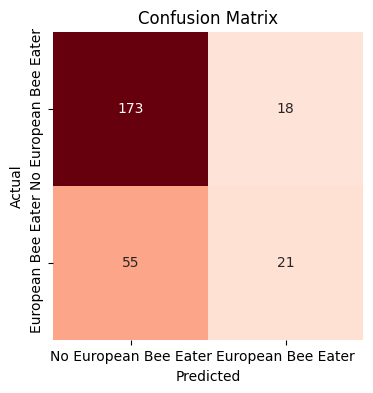


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       191
           1       0.54      0.28      0.37        76

    accuracy                           0.73       267
   macro avg       0.65      0.59      0.60       267
weighted avg       0.70      0.73      0.69       267


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       191
           1       0.54      0.28      0.37        76

    accuracy                           0.73       267
   macro avg       0.65      0.59      0.60       267
weighted avg       0.70      0.73      0.69       267



In [57]:
import seaborn as sns
# Predict probabilities for validation data
y_pred_probs = model.predict(X_val_reshaped)

# Convert probabilities to class labels
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Display confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No European Bee Eater", "European Bee Eater"])
plt.yticks(ticks=[0.5, 1.5], labels=["No European Bee Eater", "European Bee Eater"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:")
print(report)

# Compute classification report
report = classification_report(y_val, y_pred)

# Print classification report
print("\nClassification Report:")
print(report)
